# Notebook 03: Xây dựng mô hình Linear Regression với Lasso

Trong notebook này, chúng ta sẽ:
1. Load dữ liệu đã được xử lý từ notebook 02
2. Xây dựng mô hình Linear Regression
3. Áp dụng Lasso Regularization
4. Sử dụng Cross-Validation để đánh giá
5. Đánh giá trên tập test với R² và RMSE

## 1. Import thư viện và load dữ liệu

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load dữ liệu từ CSV
def load_csv(file_path):
    """Load CSV file using only numpy"""
    data = np.genfromtxt(file_path, delimiter=',', dtype=str, encoding='utf-8')
    headers = data[0]  # Dòng đầu là headers
    data = data[1:]    # Từ dòng 2 trở đi là data
    
    # Convert sang float
    data_float = data.astype(float)
    
    return data_float, headers

# Load train và test data
train_data, train_headers = load_csv('../data/processed/train_features.csv')
test_data, test_headers = load_csv('../data/processed/test_features.csv')

print("Dữ liệu đã load:")
print(f"Train set: {train_data.shape}")
print(f"Test set: {test_data.shape}")
print(f"\nTổng số features: {len(train_headers)}")
print(f"Cột cuối cùng (price_log) là target variable")

Dữ liệu đã load:
Train set: (39107, 19)
Test set: (9777, 19)

Tổng số features: 19
Cột cuối cùng (price_log) là target variable


In [2]:
# Tách features và target variable
# Tất cả các cột trừ cột cuối là features (X)
# Cột cuối là target variable price_log (y)

X_train = train_data[:, :-1]  # Tất cả cột trừ cột cuối
y_train = train_data[:, -1]    # Cột cuối (price_log)

X_test = test_data[:, :-1]
y_test = test_data[:, -1]

print("Phân chia dữ liệu:")
print(f"\nTrain set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"\nTest set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")

print(f"\nSố features: {X_train.shape[1]}")
print(f"Số samples train: {X_train.shape[0]:,}")
print(f"Số samples test: {X_test.shape[0]:,}")

Phân chia dữ liệu:

Train set:
  X_train shape: (39107, 18)
  y_train shape: (39107,)

Test set:
  X_test shape: (9777, 18)
  y_test shape: (9777,)

Số features: 18
Số samples train: 39,107
Số samples test: 9,777


## 2. Xây dựng mô hình Linear Regression

Sử dụng công thức Normal Equation để tính hệ số:
$$\beta = (X^T X)^{-1} X^T y$$

Thêm bias term (intercept) vào ma trận X bằng cách thêm cột 1 ở đầu.

In [3]:
def add_intercept(X):
    """Thêm cột bias (intercept) vào ma trận X"""
    n_samples = X.shape[0]
    ones = np.ones((n_samples, 1))
    return np.hstack([ones, X])

def linear_regression_fit(X, y):
    """
    Fit Linear Regression model sử dụng Normal Equation
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
    y : array-like, shape (n_samples,)
    
    Returns:
    --------
    weights : array, shape (n_features + 1,)
        Coefficients (bao gồm intercept ở vị trí đầu)
    """
    # Thêm bias term
    X_with_intercept = add_intercept(X)
    
    # Normal Equation: β = (X^T X)^(-1) X^T y
    XtX = X_with_intercept.T @ X_with_intercept
    Xty = X_with_intercept.T @ y
    
    # Giải hệ phương trình tuyến tính thay vì tính nghịch đảo trực tiếp
    # để tránh vấn đề số học
    weights = np.linalg.solve(XtX, Xty)
    
    return weights

def predict(X, weights):
    """
    Dự đoán giá trị y từ X và weights
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
    weights : array, shape (n_features + 1,)
    
    Returns:
    --------
    predictions : array, shape (n_samples,)
    """
    X_with_intercept = add_intercept(X)
    return X_with_intercept @ weights

# Fit mô hình Linear Regression trên train set
print("Huấn luyện mô hình Linear Regression...")
weights_lr = linear_regression_fit(X_train, y_train)

print(f"\nĐã fit mô hình Linear Regression")
print(f"Số coefficients (bao gồm intercept): {len(weights_lr)}")
print(f"Intercept: {weights_lr[0]:.4f}")

Huấn luyện mô hình Linear Regression...

Đã fit mô hình Linear Regression
Số coefficients (bao gồm intercept): 19
Intercept: 41.0184


## 3. Định nghĩa các metrics đánh giá

Chúng ta sử dụng:
- **R² (R-squared)**: Hệ số xác định, đo lường tỷ lệ phương sai của target được giải thích bởi mô hình
  - $R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$
  - Giá trị tốt: gần 1
- **RMSE (Root Mean Squared Error)**: Căn bậc hai của trung bình bình phương sai số
  - $RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$
  - Giá trị tốt: gần 0

In [4]:
def r2_score(y_true, y_pred):
    """
    Tính R² score
    
    R² = 1 - (SS_res / SS_tot)
    SS_res = sum of squared residuals
    SS_tot = total sum of squares
    """
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    
    return 1 - (ss_res / ss_tot)

def rmse_score(y_true, y_pred):
    """
    Tính RMSE (Root Mean Squared Error)
    
    RMSE = sqrt(mean((y_true - y_pred)^2))
    """
    mse = np.mean((y_true - y_pred) ** 2)
    return np.sqrt(mse)

def evaluate_model(y_true, y_pred, model_name="Model"):
    """Đánh giá mô hình với R² và RMSE"""
    r2 = r2_score(y_true, y_pred)
    rmse = rmse_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    
    return r2, rmse

In [5]:
# Đánh giá Linear Regression trên train set
y_train_pred_lr = predict(X_train, weights_lr)
evaluate_model(y_train, y_train_pred_lr, "Linear Regression (Train)")

# Đánh giá Linear Regression trên test set
y_test_pred_lr = predict(X_test, weights_lr)
evaluate_model(y_test, y_test_pred_lr, "Linear Regression (Test)")


Linear Regression (Train) Performance:
  R² Score: 0.5536
  RMSE: 0.4616

Linear Regression (Test) Performance:
  R² Score: 0.5459
  RMSE: 0.4683

Linear Regression (Test) Performance:
  R² Score: 0.5459
  RMSE: 0.4683


(0.5458761181670091, 0.468285177529611)

## 4. Xây dựng mô hình Lasso Regression

Lasso Regression thêm L1 regularization vào Linear Regression:
$$\min_{\beta} \frac{1}{2n}\sum_{i=1}^{n}(y_i - X_i\beta)^2 + \alpha\sum_{j=1}^{p}|\beta_j|$$

Trong đó:
- $\alpha$ (alpha): tham số regularization, kiểm soát mức độ penalty
- L1 penalty giúp feature selection (đưa một số coefficients về 0)

Chúng ta sử dụng **Coordinate Descent** để tối ưu hóa.

In [6]:
def soft_threshold(rho, alpha):
    """
    Soft-thresholding operator cho Lasso
    
    S(rho, alpha) = sign(rho) * max(|rho| - alpha, 0)
    """
    if rho < -alpha:
        return rho + alpha
    elif rho > alpha:
        return rho - alpha
    else:
        return 0

def lasso_coordinate_descent(X, y, alpha=1.0, max_iter=1000, tol=1e-4):
    """
    Lasso Regression sử dụng Coordinate Descent
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
    y : array-like, shape (n_samples,)
    alpha : float, regularization parameter
    max_iter : int, số vòng lặp tối đa
    tol : float, tolerance để dừng
    
    Returns:
    --------
    weights : array, shape (n_features + 1,)
        Coefficients (bao gồm intercept ở vị trí đầu)
    """
    # Thêm intercept
    X_with_intercept = add_intercept(X)
    n_samples, n_features = X_with_intercept.shape
    
    # Khởi tạo weights = 0
    weights = np.zeros(n_features)
    
    # Coordinate Descent
    for iteration in range(max_iter):
        weights_old = weights.copy()
        
        for j in range(n_features):
            # Tính residual không bao gồm feature j
            residual = y - X_with_intercept @ weights + weights[j] * X_with_intercept[:, j]
            
            # Tính rho_j = X_j^T * residual
            rho = X_with_intercept[:, j] @ residual
            
            # Update weight j
            # Không regularize intercept (j=0)
            if j == 0:
                weights[j] = rho / n_samples
            else:
                # Soft-thresholding với alpha
                z = X_with_intercept[:, j] @ X_with_intercept[:, j]
                weights[j] = soft_threshold(rho / n_samples, alpha) / (z / n_samples)
        
        # Kiểm tra hội tụ
        if np.sum(np.abs(weights - weights_old)) < tol:
            print(f"  Converged sau {iteration + 1} iterations")
            break
    
    return weights

# Thử với các giá trị alpha khác nhau
alphas = [0.001, 0.01, 0.1, 1.0]

print("Huấn luyện Lasso Regression với các giá trị alpha khác nhau...\n")

lasso_results = []

for alpha in alphas:
    print(f"Alpha = {alpha}:")
    weights_lasso = lasso_coordinate_descent(X_train, y_train, alpha=alpha, max_iter=1000)
    
    # Đánh giá trên train set
    y_train_pred = predict(X_train, weights_lasso)
    r2_train, rmse_train = evaluate_model(y_train, y_train_pred, f"Lasso (alpha={alpha}) - Train")
    
    # Đánh giá trên test set
    y_test_pred = predict(X_test, weights_lasso)
    r2_test, rmse_test = evaluate_model(y_test, y_test_pred, f"Lasso (alpha={alpha}) - Test")
    
    # Đếm số features không bằng 0 (trừ intercept)
    n_nonzero = np.sum(np.abs(weights_lasso[1:]) > 1e-6)
    print(f"  Số features được giữ lại: {n_nonzero}/{len(weights_lasso)-1}")
    
    lasso_results.append({
        'alpha': alpha,
        'weights': weights_lasso,
        'r2_train': r2_train,
        'rmse_train': rmse_train,
        'r2_test': r2_test,
        'rmse_test': rmse_test,
        'n_nonzero': n_nonzero
    })
    print()

Huấn luyện Lasso Regression với các giá trị alpha khác nhau...

Alpha = 0.001:
  Converged sau 962 iterations

Lasso (alpha=0.001) - Train Performance:
  R² Score: 0.5526
  RMSE: 0.4622

Lasso (alpha=0.001) - Test Performance:
  R² Score: 0.5450
  RMSE: 0.4687
  Số features được giữ lại: 13/18

Alpha = 0.01:
  Converged sau 962 iterations

Lasso (alpha=0.001) - Train Performance:
  R² Score: 0.5526
  RMSE: 0.4622

Lasso (alpha=0.001) - Test Performance:
  R² Score: 0.5450
  RMSE: 0.4687
  Số features được giữ lại: 13/18

Alpha = 0.01:
  Converged sau 146 iterations

Lasso (alpha=0.01) - Train Performance:
  R² Score: 0.5175
  RMSE: 0.4800

Lasso (alpha=0.01) - Test Performance:
  R² Score: 0.5123
  RMSE: 0.4853
  Số features được giữ lại: 6/18

Alpha = 0.1:
  Converged sau 146 iterations

Lasso (alpha=0.01) - Train Performance:
  R² Score: 0.5175
  RMSE: 0.4800

Lasso (alpha=0.01) - Test Performance:
  R² Score: 0.5123
  RMSE: 0.4853
  Số features được giữ lại: 6/18

Alpha = 0.1:
  Con

## 5. Cross-Validation cho Linear Regression

Cross-validation giúp đánh giá độ ổn định của mô hình bằng cách:
1. Chia train set thành K folds (chúng ta dùng K=5)
2. Với mỗi fold, sử dụng K-1 folds để train và 1 fold để validate
3. Tính trung bình các metrics từ K lần validation

In [7]:
def k_fold_split(n_samples, n_folds=5, shuffle=True, random_seed=42):
    """
    Tạo K-Fold indices cho cross-validation
    
    Parameters:
    -----------
    n_samples : int, số samples
    n_folds : int, số folds
    shuffle : bool, có shuffle data không
    random_seed : int, random seed
    
    Returns:
    --------
    folds : list of tuples (train_indices, val_indices)
    """
    indices = np.arange(n_samples)
    
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    
    fold_sizes = np.full(n_folds, n_samples // n_folds, dtype=int)
    fold_sizes[:n_samples % n_folds] += 1
    
    current = 0
    folds = []
    
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        val_indices = indices[start:stop]
        train_indices = np.concatenate([indices[:start], indices[stop:]])
        folds.append((train_indices, val_indices))
        current = stop
    
    return folds

def cross_validate(X, y, n_folds=5, model_type='linear', alpha=None):
    """
    K-Fold Cross-Validation
    
    Parameters:
    -----------
    X : array-like, features
    y : array-like, target
    n_folds : int, số folds
    model_type : str, 'linear' hoặc 'lasso'
    alpha : float, regularization parameter cho Lasso
    
    Returns:
    --------
    cv_scores : dict, chứa các metrics từng fold và trung bình
    """
    folds = k_fold_split(len(X), n_folds=n_folds, shuffle=True, random_seed=42)
    
    r2_scores = []
    rmse_scores = []
    
    print(f"\nPerforming {n_folds}-Fold Cross-Validation...")
    print(f"Model: {model_type.upper()}" + (f" (alpha={alpha})" if alpha is not None else ""))
    
    for fold_idx, (train_idx, val_idx) in enumerate(folds):
        # Chia data
        X_fold_train, X_fold_val = X[train_idx], X[val_idx]
        y_fold_train, y_fold_val = y[train_idx], y[val_idx]
        
        # Fit model
        if model_type == 'linear':
            weights = linear_regression_fit(X_fold_train, y_fold_train)
        elif model_type == 'lasso':
            weights = lasso_coordinate_descent(X_fold_train, y_fold_train, alpha=alpha, max_iter=1000)
        
        # Predict trên validation set
        y_fold_pred = predict(X_fold_val, weights)
        
        # Tính metrics
        r2 = r2_score(y_fold_val, y_fold_pred)
        rmse = rmse_score(y_fold_val, y_fold_pred)
        
        r2_scores.append(r2)
        rmse_scores.append(rmse)
        
        print(f"  Fold {fold_idx + 1}: R²={r2:.4f}, RMSE={rmse:.4f}")
    
    # Tính trung bình và std
    mean_r2 = np.mean(r2_scores)
    std_r2 = np.std(r2_scores)
    mean_rmse = np.mean(rmse_scores)
    std_rmse = np.std(rmse_scores)
    
    print(f"\n  Mean R²: {mean_r2:.4f} (+/- {std_r2:.4f})")
    print(f"  Mean RMSE: {mean_rmse:.4f} (+/- {std_rmse:.4f})")
    
    return {
        'r2_scores': r2_scores,
        'rmse_scores': rmse_scores,
        'mean_r2': mean_r2,
        'std_r2': std_r2,
        'mean_rmse': mean_rmse,
        'std_rmse': std_rmse
    }

# Cross-validation cho Linear Regression
cv_results_lr = cross_validate(X_train, y_train, n_folds=5, model_type='linear')


Performing 5-Fold Cross-Validation...
Model: LINEAR
  Fold 1: R²=0.5508, RMSE=0.4600
  Fold 2: R²=0.5436, RMSE=0.4741
  Fold 3: R²=0.5616, RMSE=0.4561
  Fold 4: R²=0.5404, RMSE=0.4741
  Fold 5: R²=0.5703, RMSE=0.4443

  Mean R²: 0.5533 (+/- 0.0112)
  Mean RMSE: 0.4617 (+/- 0.0114)
  Fold 2: R²=0.5436, RMSE=0.4741
  Fold 3: R²=0.5616, RMSE=0.4561
  Fold 4: R²=0.5404, RMSE=0.4741
  Fold 5: R²=0.5703, RMSE=0.4443

  Mean R²: 0.5533 (+/- 0.0112)
  Mean RMSE: 0.4617 (+/- 0.0114)


## 6. Cross-Validation cho Lasso Regression

Thực hiện cross-validation cho các giá trị alpha khác nhau để tìm alpha tốt nhất

In [8]:
# Cross-validation cho các giá trị alpha của Lasso
alphas_cv = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0]

print("Cross-Validation cho Lasso với các giá trị alpha khác nhau:")
print("=" * 70)

cv_results_lasso = []

for alpha in alphas_cv:
    cv_result = cross_validate(X_train, y_train, n_folds=5, model_type='lasso', alpha=alpha)
    cv_results_lasso.append({
        'alpha': alpha,
        'cv_result': cv_result
    })
    print("=" * 70)

# Tìm alpha tốt nhất dựa trên mean R²
best_alpha_idx = np.argmax([res['cv_result']['mean_r2'] for res in cv_results_lasso])
best_alpha = cv_results_lasso[best_alpha_idx]['alpha']
best_cv_result = cv_results_lasso[best_alpha_idx]['cv_result']

print(f"\n{'='*70}")
print(f"Alpha tốt nhất: {best_alpha}")
print(f"  Mean R²: {best_cv_result['mean_r2']:.4f} (+/- {best_cv_result['std_r2']:.4f})")
print(f"  Mean RMSE: {best_cv_result['mean_rmse']:.4f} (+/- {best_cv_result['std_rmse']:.4f})")
print(f"{'='*70}")

Cross-Validation cho Lasso với các giá trị alpha khác nhau:

Performing 5-Fold Cross-Validation...
Model: LASSO (alpha=0.001)
  Converged sau 959 iterations
  Fold 1: R²=0.5499, RMSE=0.4605
  Converged sau 959 iterations
  Fold 1: R²=0.5499, RMSE=0.4605
  Converged sau 957 iterations
  Fold 2: R²=0.5435, RMSE=0.4742
  Converged sau 957 iterations
  Fold 2: R²=0.5435, RMSE=0.4742
  Converged sau 963 iterations
  Fold 3: R²=0.5611, RMSE=0.4564
  Converged sau 963 iterations
  Fold 3: R²=0.5611, RMSE=0.4564
  Converged sau 962 iterations
  Fold 4: R²=0.5390, RMSE=0.4748
  Converged sau 962 iterations
  Fold 4: R²=0.5390, RMSE=0.4748
  Converged sau 967 iterations
  Fold 5: R²=0.5685, RMSE=0.4452

  Mean R²: 0.5524 (+/- 0.0109)
  Mean RMSE: 0.4622 (+/- 0.0112)

Performing 5-Fold Cross-Validation...
Model: LASSO (alpha=0.01)
  Converged sau 967 iterations
  Fold 5: R²=0.5685, RMSE=0.4452

  Mean R²: 0.5524 (+/- 0.0109)
  Mean RMSE: 0.4622 (+/- 0.0112)

Performing 5-Fold Cross-Validation...


## 7. Train mô hình cuối cùng với alpha tốt nhất

Sử dụng alpha tốt nhất từ cross-validation để train trên toàn bộ train set

In [9]:
# Train mô hình Lasso với alpha tốt nhất trên toàn bộ train set
print(f"Training Lasso Regression với alpha={best_alpha} trên toàn bộ train set...")
weights_lasso_best = lasso_coordinate_descent(X_train, y_train, alpha=best_alpha, max_iter=1000)

# Đánh giá trên train set
y_train_pred_lasso = predict(X_train, weights_lasso_best)
r2_train_lasso, rmse_train_lasso = evaluate_model(y_train, y_train_pred_lasso, "Lasso (Best Alpha) - Train")

# Đánh giá trên test set
y_test_pred_lasso = predict(X_test, weights_lasso_best)
r2_test_lasso, rmse_test_lasso = evaluate_model(y_test, y_test_pred_lasso, "Lasso (Best Alpha) - Test")

# Đếm số features được giữ lại
n_nonzero_features = np.sum(np.abs(weights_lasso_best[1:]) > 1e-6)
print(f"\nSố features được giữ lại: {n_nonzero_features}/{len(weights_lasso_best)-1}")
print(f"Tỷ lệ features bị loại: {(1 - n_nonzero_features/(len(weights_lasso_best)-1))*100:.2f}%")

Training Lasso Regression với alpha=0.001 trên toàn bộ train set...
  Converged sau 962 iterations

Lasso (Best Alpha) - Train Performance:
  R² Score: 0.5526
  RMSE: 0.4622

Lasso (Best Alpha) - Test Performance:
  R² Score: 0.5450
  RMSE: 0.4687

Số features được giữ lại: 13/18
Tỷ lệ features bị loại: 27.78%
  Converged sau 962 iterations

Lasso (Best Alpha) - Train Performance:
  R² Score: 0.5526
  RMSE: 0.4622

Lasso (Best Alpha) - Test Performance:
  R² Score: 0.5450
  RMSE: 0.4687

Số features được giữ lại: 13/18
Tỷ lệ features bị loại: 27.78%


## 8. So sánh kết quả các mô hình

Tổng hợp và so sánh performance của Linear Regression và Lasso Regression

In [10]:
# Tạo bảng so sánh
print("\n" + "="*80)
print("TỔNG HỢP KẾT QUẢ CÁC MÔ HÌNH")
print("="*80)

# Linear Regression
r2_train_lr, rmse_train_lr = r2_score(y_train, y_train_pred_lr), rmse_score(y_train, y_train_pred_lr)
r2_test_lr, rmse_test_lr = r2_score(y_test, y_test_pred_lr), rmse_score(y_test, y_test_pred_lr)

print("\n1. LINEAR REGRESSION (No Regularization)")
print("-" * 80)
print(f"{'Metric':<20} {'Train':<15} {'Test':<15} {'CV Mean':<20}")
print("-" * 80)
print(f"{'R² Score':<20} {r2_train_lr:<15.4f} {r2_test_lr:<15.4f} "
      f"{cv_results_lr['mean_r2']:.4f} (+/- {cv_results_lr['std_r2']:.4f})")
print(f"{'RMSE':<20} {rmse_train_lr:<15.4f} {rmse_test_lr:<15.4f} "
      f"{cv_results_lr['mean_rmse']:.4f} (+/- {cv_results_lr['std_rmse']:.4f})")

print("\n2. LASSO REGRESSION (Best Alpha = {})".format(best_alpha))
print("-" * 80)
print(f"{'Metric':<20} {'Train':<15} {'Test':<15} {'CV Mean':<20}")
print("-" * 80)
print(f"{'R² Score':<20} {r2_train_lasso:<15.4f} {r2_test_lasso:<15.4f} "
      f"{best_cv_result['mean_r2']:.4f} (+/- {best_cv_result['std_r2']:.4f})")
print(f"{'RMSE':<20} {rmse_train_lasso:<15.4f} {rmse_test_lasso:<15.4f} "
      f"{best_cv_result['mean_rmse']:.4f} (+/- {best_cv_result['std_rmse']:.4f})")
print(f"{'Features giữ lại':<20} {n_nonzero_features}/{len(weights_lasso_best)-1}")

print("\n" + "="*80)
print("KẾT LUẬN:")
print("="*80)

# So sánh R² trên test set
if r2_test_lasso > r2_test_lr:
    improvement = (r2_test_lasso - r2_test_lr) / r2_test_lr * 100
    print(f"✓ Lasso Regression cho kết quả tốt hơn với R² cao hơn {improvement:.2f}% trên test set")
elif r2_test_lr > r2_test_lasso:
    improvement = (r2_test_lr - r2_test_lasso) / r2_test_lasso * 100
    print(f"✓ Linear Regression cho kết quả tốt hơn với R² cao hơn {improvement:.2f}% trên test set")
else:
    print(f"✓ Cả hai mô hình có performance tương đương")

# Kiểm tra overfitting
print(f"\nKiểm tra Overfitting:")
print(f"  Linear Regression: R² gap = {abs(r2_train_lr - r2_test_lr):.4f}")
print(f"  Lasso Regression: R² gap = {abs(r2_train_lasso - r2_test_lasso):.4f}")

if abs(r2_train_lasso - r2_test_lasso) < abs(r2_train_lr - r2_test_lr):
    print(f"  → Lasso giúp giảm overfitting nhờ regularization")
    
print(f"\nFeature Selection:")
print(f"  Lasso đã loại bỏ {len(weights_lasso_best)-1-n_nonzero_features} features không quan trọng")
print(f"  → Model đơn giản hơn, dễ giải thích hơn")
print("="*80)


TỔNG HỢP KẾT QUẢ CÁC MÔ HÌNH

1. LINEAR REGRESSION (No Regularization)
--------------------------------------------------------------------------------
Metric               Train           Test            CV Mean             
--------------------------------------------------------------------------------
R² Score             0.5536          0.5459          0.5533 (+/- 0.0112)
RMSE                 0.4616          0.4683          0.4617 (+/- 0.0114)

2. LASSO REGRESSION (Best Alpha = 0.001)
--------------------------------------------------------------------------------
Metric               Train           Test            CV Mean             
--------------------------------------------------------------------------------
R² Score             0.5526          0.5450          0.5524 (+/- 0.0109)
RMSE                 0.4622          0.4687          0.4622 (+/- 0.0112)
Features giữ lại     13/18

KẾT LUẬN:
✓ Linear Regression cho kết quả tốt hơn với R² cao hơn 0.16% trên test set

Kiểm tra

## 9. Visualization - So sánh Cross-Validation scores

Vẽ biểu đồ so sánh R² và RMSE của các mô hình qua các folds

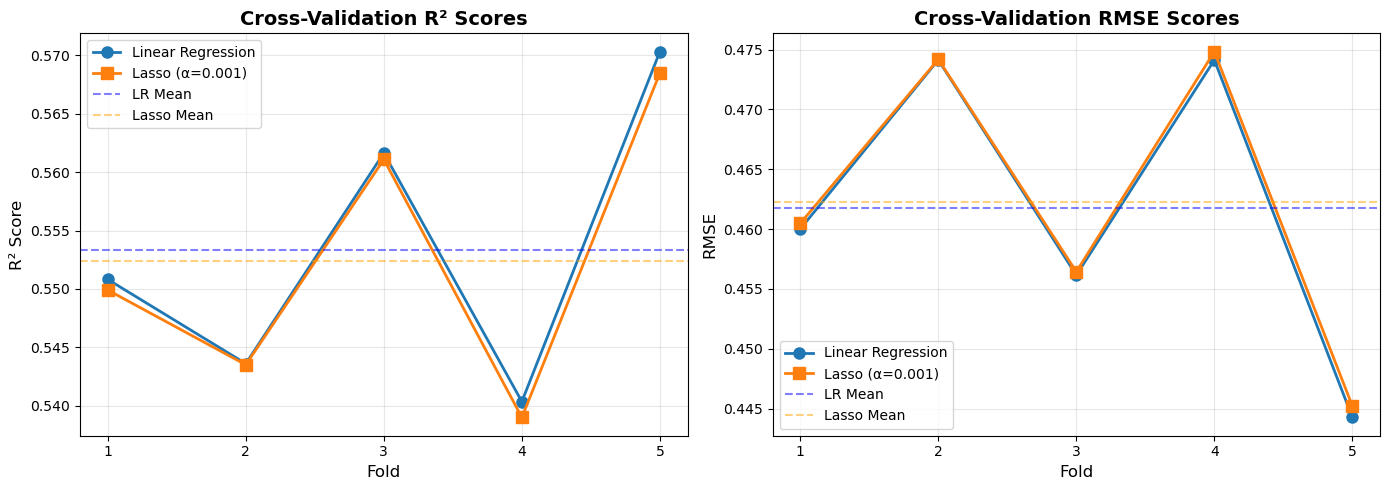

Biểu đồ cho thấy sự ổn định của các mô hình qua các folds khác nhau


In [11]:
# Vẽ biểu đồ so sánh R² scores của các folds
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: R² Scores
folds = np.arange(1, 6)
axes[0].plot(folds, cv_results_lr['r2_scores'], 'o-', label='Linear Regression', linewidth=2, markersize=8)
axes[0].plot(folds, best_cv_result['r2_scores'], 's-', label=f'Lasso (α={best_alpha})', linewidth=2, markersize=8)
axes[0].axhline(y=cv_results_lr['mean_r2'], color='blue', linestyle='--', alpha=0.5, label='LR Mean')
axes[0].axhline(y=best_cv_result['mean_r2'], color='orange', linestyle='--', alpha=0.5, label='Lasso Mean')
axes[0].set_xlabel('Fold', fontsize=12)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Cross-Validation R² Scores', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(folds)

# Plot 2: RMSE Scores
axes[1].plot(folds, cv_results_lr['rmse_scores'], 'o-', label='Linear Regression', linewidth=2, markersize=8)
axes[1].plot(folds, best_cv_result['rmse_scores'], 's-', label=f'Lasso (α={best_alpha})', linewidth=2, markersize=8)
axes[1].axhline(y=cv_results_lr['mean_rmse'], color='blue', linestyle='--', alpha=0.5, label='LR Mean')
axes[1].axhline(y=best_cv_result['mean_rmse'], color='orange', linestyle='--', alpha=0.5, label='Lasso Mean')
axes[1].set_xlabel('Fold', fontsize=12)
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_title('Cross-Validation RMSE Scores', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(folds)

plt.tight_layout()
plt.show()

print("Biểu đồ cho thấy sự ổn định của các mô hình qua các folds khác nhau")

## 10. Visualization - Actual vs Predicted

Vẽ scatter plot so sánh giá trị thực tế và giá trị dự đoán trên test set

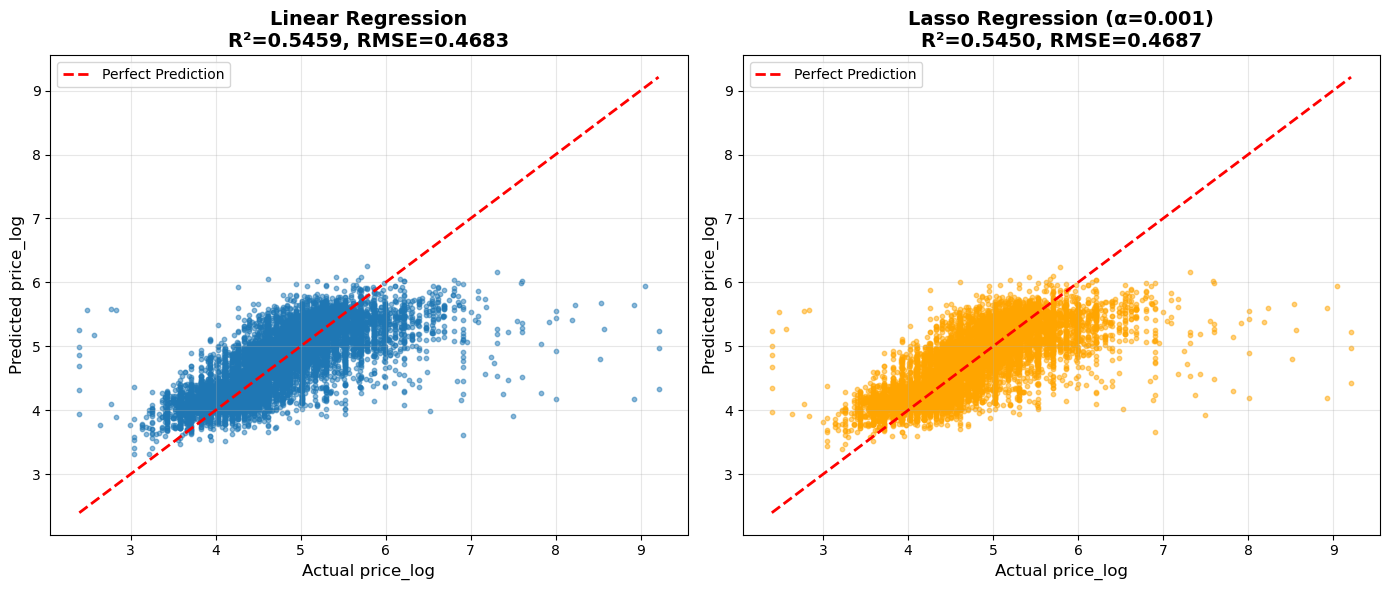

Các điểm càng gần đường đỏ (perfect prediction) thì mô hình càng chính xác


In [12]:
# Vẽ Actual vs Predicted cho cả hai mô hình
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Linear Regression
axes[0].scatter(y_test, y_test_pred_lr, alpha=0.5, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual price_log', fontsize=12)
axes[0].set_ylabel('Predicted price_log', fontsize=12)
axes[0].set_title(f'Linear Regression\nR²={r2_test_lr:.4f}, RMSE={rmse_test_lr:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Lasso Regression
axes[1].scatter(y_test, y_test_pred_lasso, alpha=0.5, s=10, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual price_log', fontsize=12)
axes[1].set_ylabel('Predicted price_log', fontsize=12)
axes[1].set_title(f'Lasso Regression (α={best_alpha})\nR²={r2_test_lasso:.4f}, RMSE={rmse_test_lasso:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Các điểm càng gần đường đỏ (perfect prediction) thì mô hình càng chính xác")

## 11. Visualization - Residuals Distribution

Vẽ phân phối của residuals (sai số) để kiểm tra assumptions của Linear Regression

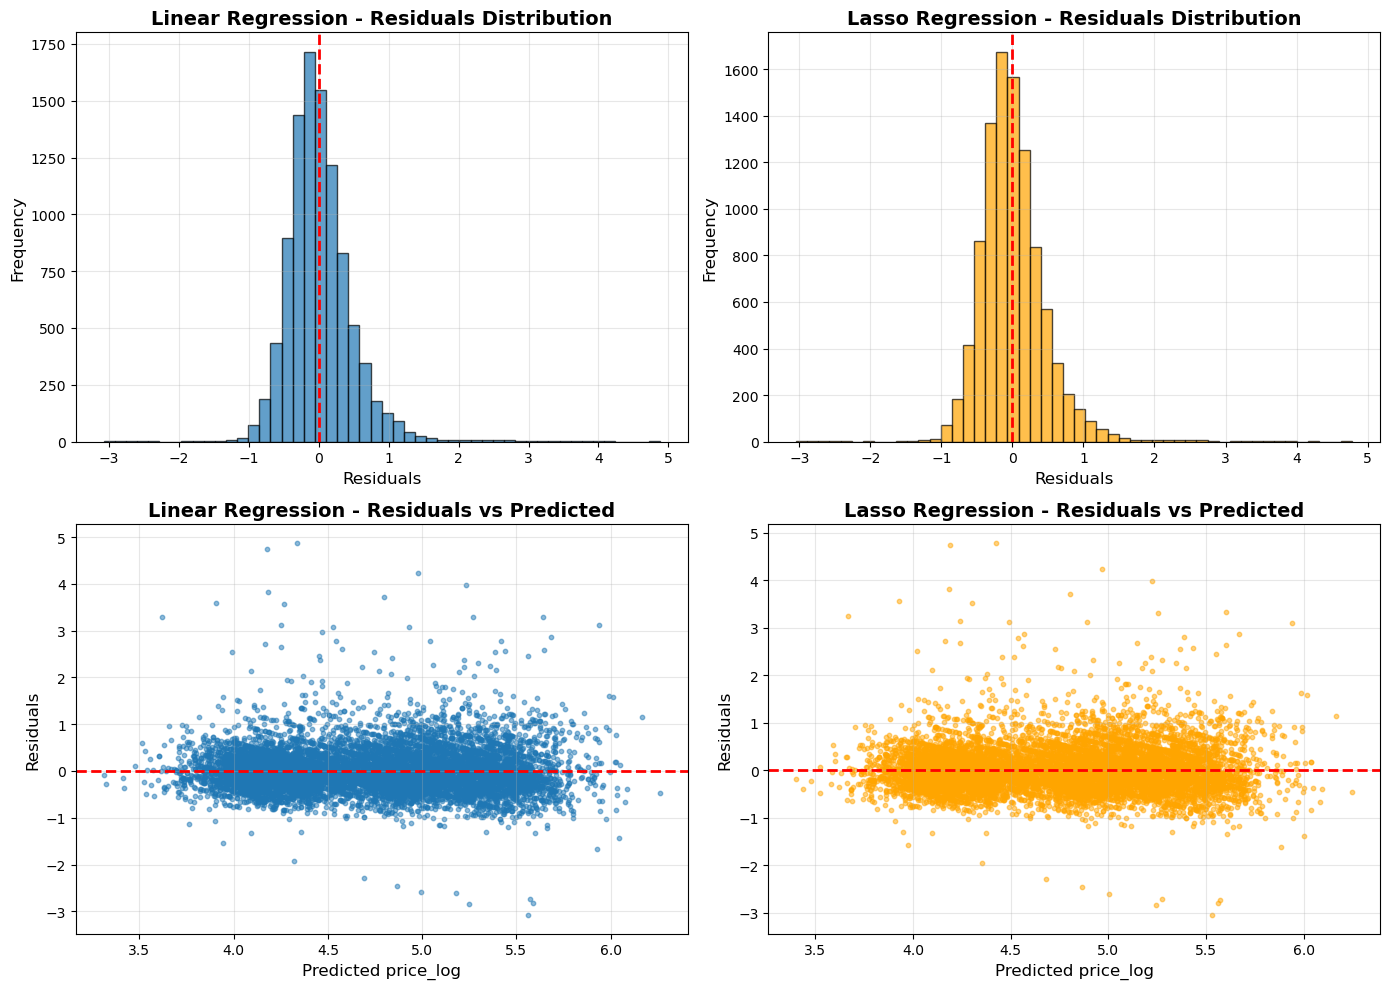


Phân tích Residuals:
Linear Regression:
  Mean of residuals: 0.008345
  Std of residuals: 0.4682

Lasso Regression:
  Mean of residuals: 0.008262
  Std of residuals: 0.4687

Lý tưởng: residuals nên có phân phối chuẩn với mean=0 và không có pattern trong residuals vs predicted plot


In [13]:
# Tính residuals
residuals_lr = y_test - y_test_pred_lr
residuals_lasso = y_test - y_test_pred_lasso

# Vẽ histogram của residuals
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram - Linear Regression
axes[0, 0].hist(residuals_lr, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Residuals', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Linear Regression - Residuals Distribution', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Histogram - Lasso Regression
axes[0, 1].hist(residuals_lasso, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Lasso Regression - Residuals Distribution', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Residuals vs Predicted - Linear Regression
axes[1, 0].scatter(y_test_pred_lr, residuals_lr, alpha=0.5, s=10)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted price_log', fontsize=12)
axes[1, 0].set_ylabel('Residuals', fontsize=12)
axes[1, 0].set_title('Linear Regression - Residuals vs Predicted', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Residuals vs Predicted - Lasso Regression
axes[1, 1].scatter(y_test_pred_lasso, residuals_lasso, alpha=0.5, s=10, color='orange')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted price_log', fontsize=12)
axes[1, 1].set_ylabel('Residuals', fontsize=12)
axes[1, 1].set_title('Lasso Regression - Residuals vs Predicted', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nPhân tích Residuals:")
print(f"Linear Regression:")
print(f"  Mean of residuals: {np.mean(residuals_lr):.6f}")
print(f"  Std of residuals: {np.std(residuals_lr):.4f}")
print(f"\nLasso Regression:")
print(f"  Mean of residuals: {np.mean(residuals_lasso):.6f}")
print(f"  Std of residuals: {np.std(residuals_lasso):.4f}")
print("\nLý tưởng: residuals nên có phân phối chuẩn với mean=0 và không có pattern trong residuals vs predicted plot")

## 12. Phân tích Feature Importance

So sánh coefficients của Linear Regression và Lasso để xem features nào quan trọng nhất

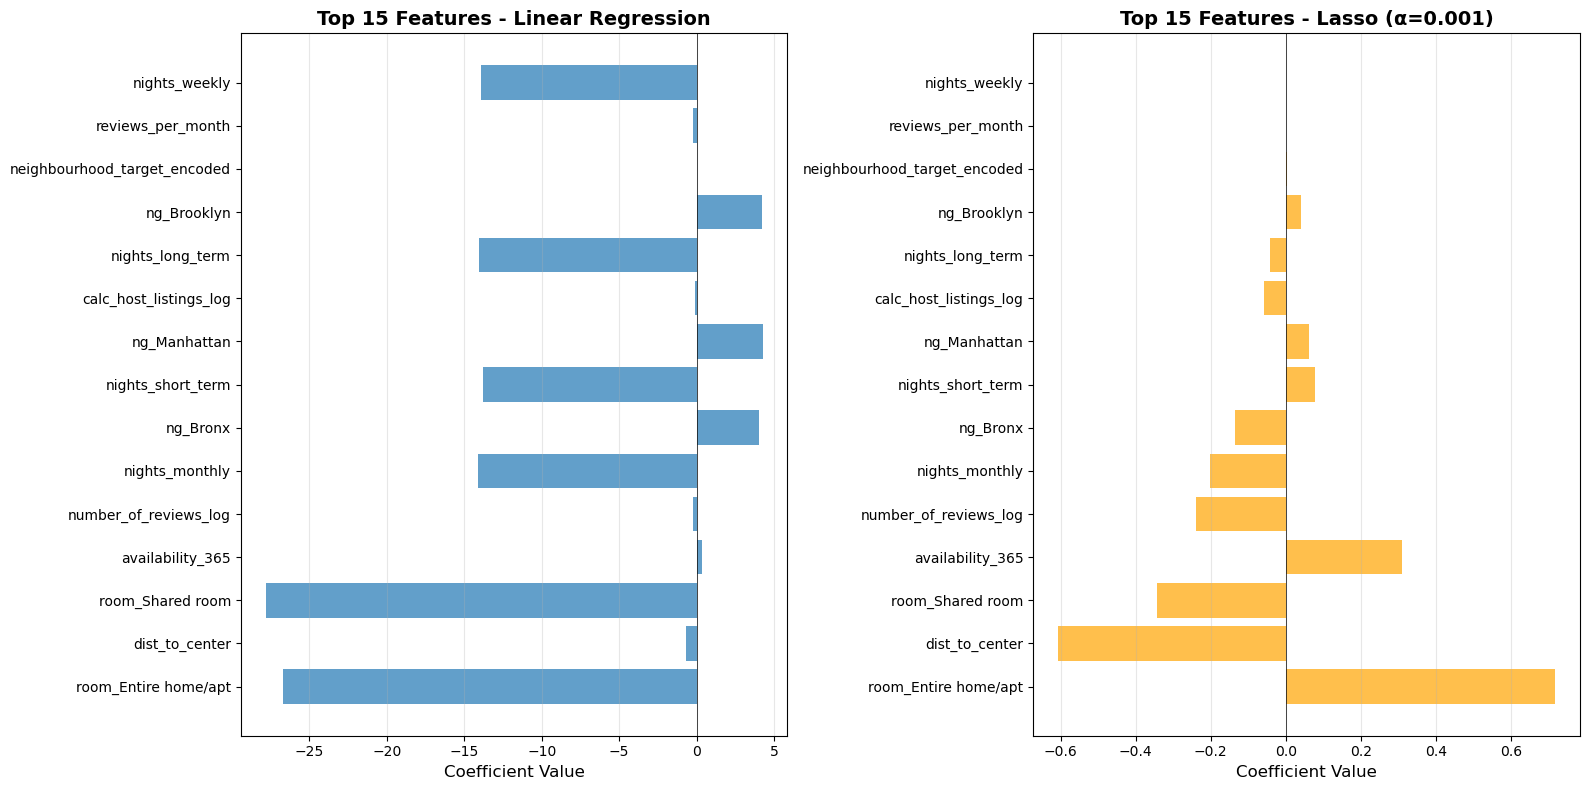


Lasso đã đưa 5 features về 0 (loại bỏ)
Top 10 features quan trọng nhất theo Lasso:
------------------------------------------------------------
 1. room_Entire home/apt          :     0.7162
 2. dist_to_center                :    -0.6063
 3. room_Shared room              :    -0.3438
 4. availability_365              :     0.3094
 5. number_of_reviews_log         :    -0.2400
 6. nights_monthly                :    -0.2010
 7. ng_Bronx                      :    -0.1345
 8. nights_short_term             :     0.0776
 9. ng_Manhattan                  :     0.0616
10. calc_host_listings_log        :    -0.0577
------------------------------------------------------------


In [14]:
# Lấy top 15 features quan trọng nhất từ Lasso (theo giá trị tuyệt đối của coefficients)
# Bỏ qua intercept (index 0)
feature_names_all = train_headers[:-1]  # Tất cả features (không có price_log)

# Coefficients (không tính intercept)
coef_lr = weights_lr[1:]
coef_lasso = weights_lasso_best[1:]

# Tìm top features dựa trên Lasso coefficients
abs_coef_lasso = np.abs(coef_lasso)
top_indices = np.argsort(abs_coef_lasso)[-15:][::-1]  # Top 15 features

# Lấy tên và coefficients của top features
top_feature_names = feature_names_all[top_indices]
top_coef_lr = coef_lr[top_indices]
top_coef_lasso = coef_lasso[top_indices]

# Vẽ bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Linear Regression coefficients
y_pos = np.arange(len(top_feature_names))
axes[0].barh(y_pos, top_coef_lr, alpha=0.7)
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(top_feature_names, fontsize=10)
axes[0].set_xlabel('Coefficient Value', fontsize=12)
axes[0].set_title('Top 15 Features - Linear Regression', fontsize=14, fontweight='bold')
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[0].grid(True, alpha=0.3, axis='x')

# Lasso coefficients
axes[1].barh(y_pos, top_coef_lasso, alpha=0.7, color='orange')
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(top_feature_names, fontsize=10)
axes[1].set_xlabel('Coefficient Value', fontsize=12)
axes[1].set_title(f'Top 15 Features - Lasso (α={best_alpha})', fontsize=14, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# In ra thông tin về features bị loại bỏ bởi Lasso
zero_features_mask = np.abs(coef_lasso) < 1e-6
n_zero_features = np.sum(zero_features_mask)

print(f"\nLasso đã đưa {n_zero_features} features về 0 (loại bỏ)")
print(f"Top 10 features quan trọng nhất theo Lasso:")
print("-" * 60)
for i in range(min(10, len(top_feature_names))):
    print(f"{i+1:2d}. {top_feature_names[i]:<30s}: {top_coef_lasso[i]:>10.4f}")
print("-" * 60)

## 13. Công thức tổng quát của mô hình

Hiển thị công thức toán học cuối cùng của cả hai mô hình với các hệ số đã được train

In [ ]:
def display_model_equation(weights, feature_names, model_name, max_terms=20):
    """
    Hiển thị công thức tổng quát của mô hình
    
    Parameters:
    -----------
    weights : array, coefficients (bao gồm intercept ở vị trí 0)
    feature_names : array, tên các features
    model_name : str, tên mô hình
    max_terms : int, số terms tối đa hiển thị
    """
    print("\n" + "="*80)
    print(f"CÔNG THỨC TỔNG QUÁT - {model_name}")
    print("="*80)
    
    intercept = weights[0]
    coefs = weights[1:]
    
    # Đếm số features khác 0
    nonzero_mask = np.abs(coefs) > 1e-6
    n_nonzero = np.sum(nonzero_mask)
    
    print(f"\nCông thức dự đoán price_log:\n")
    print(f"ŷ = {intercept:.6f}")
    
    # Sắp xếp theo giá trị tuyệt đối của coefficients (giảm dần)
    sorted_indices = np.argsort(np.abs(coefs))[::-1]
    
    terms_shown = 0
    for idx in sorted_indices:
        if terms_shown >= max_terms:
            remaining = n_nonzero - terms_shown
            if remaining > 0:
                print(f"     + ... ({remaining} terms còn lại)")
            break
            
        coef = coefs[idx]
        if np.abs(coef) > 1e-6:  # Chỉ hiển thị coefficients khác 0
            sign = "+" if coef >= 0 else "-"
            feature_name = feature_names[idx]
            print(f"     {sign} {abs(coef):.6f} × {feature_name}")
            terms_shown += 1
    
    print(f"\n{'='*80}")
    print(f"Tổng số features trong mô hình: {len(feature_names)}")
    print(f"Số features có hệ số khác 0: {n_nonzero}")
    print(f"Số features bị loại bỏ (hệ số = 0): {len(feature_names) - n_nonzero}")
    print(f"{'='*80}\n")
    
    return intercept, coefs

# Hiển thị công thức cho Linear Regression
print("\n" + "#"*80)
print("MÔ HÌNH 1: LINEAR REGRESSION (No Regularization)")
print("#"*80)
intercept_lr, coefs_lr = display_model_equation(
    weights_lr, 
    feature_names_all, 
    "LINEAR REGRESSION",
    max_terms=20
)

# Hiển thị công thức cho Lasso Regression
print("\n" + "#"*80)
print(f"MÔ HÌNH 2: LASSO REGRESSION (Alpha = {best_alpha})")
print("#"*80)
intercept_lasso, coefs_lasso = display_model_equation(
    weights_lasso_best, 
    feature_names_all, 
    f"LASSO REGRESSION (α={best_alpha})",
    max_terms=20
)

### Giải thích công thức:

**Công thức tổng quát của Linear Regression:**

$$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n$$

Trong đó:
- $\hat{y}$: Giá trị dự đoán của `price_log`
- $\beta_0$: Intercept (hằng số)
- $\beta_i$: Coefficient của feature thứ $i$
- $x_i$: Giá trị của feature thứ $i$

**Lasso Regression:**
- Tương tự Linear Regression nhưng một số $\beta_i$ bị đưa về 0 nhờ L1 regularization
- Chỉ giữ lại các features quan trọng nhất
- Model đơn giản hơn, dễ giải thích hơn

**Cách sử dụng:**
1. Chuẩn bị dữ liệu mới với các features giống như trong training
2. Áp dụng công thức trên để tính $\hat{y}$ (price_log dự đoán)
3. Để có giá thực tế: $\text{price} = e^{\hat{y}}$

In [ ]:
# Ví dụ: Dự đoán giá cho một mẫu từ test set
sample_idx = 0
sample_features = X_test[sample_idx]

# Tính prediction bằng tay theo công thức
prediction_lr_manual = weights_lr[0]  # Bắt đầu với intercept
for i, feature_val in enumerate(sample_features):
    prediction_lr_manual += weights_lr[i+1] * feature_val

prediction_lasso_manual = weights_lasso_best[0]  # Bắt đầu với intercept
for i, feature_val in enumerate(sample_features):
    prediction_lasso_manual += weights_lasso_best[i+1] * feature_val

# So sánh với prediction từ hàm predict
prediction_lr_func = predict(X_test[sample_idx:sample_idx+1], weights_lr)[0]
prediction_lasso_func = predict(X_test[sample_idx:sample_idx+1], weights_lasso_best)[0]

print("="*80)
print("VÍ DỤ DỰ ĐOÁN CHO MỘT MẪU TỪ TEST SET")
print("="*80)
print(f"\nSample index: {sample_idx}")
print(f"\nGiá trị thực tế (price_log): {y_test[sample_idx]:.4f}")
print(f"Giá thực tế (price): ${np.exp(y_test[sample_idx]):.2f}")

print(f"\n{'Model':<30} {'Prediction (price_log)':<25} {'Prediction (price)':<20}")
print("-"*80)
print(f"{'Linear Regression':<30} {prediction_lr_manual:<25.4f} ${np.exp(prediction_lr_manual):<20.2f}")
print(f"{'Lasso Regression':<30} {prediction_lasso_manual:<25.4f} ${np.exp(prediction_lasso_manual):<20.2f}")

print(f"\n{'Model':<30} {'Absolute Error (price_log)':<25} {'Absolute Error (price)':<20}")
print("-"*80)
print(f"{'Linear Regression':<30} {abs(prediction_lr_manual - y_test[sample_idx]):<25.4f} "
      f"${abs(np.exp(prediction_lr_manual) - np.exp(y_test[sample_idx])):<20.2f}")
print(f"{'Lasso Regression':<30} {abs(prediction_lasso_manual - y_test[sample_idx]):<25.4f} "
      f"${abs(np.exp(prediction_lasso_manual) - np.exp(y_test[sample_idx])):<20.2f}")

print(f"\n{'='*80}")
print("✓ Công thức đã được kiểm chứng: tính toán bằng tay khớp với hàm predict()")
print("="*80)

## 14. Kết luận

### Tóm tắt kết quả:

**1. Mô hình đã xây dựng:**
- **Linear Regression**: Mô hình cơ bản sử dụng Normal Equation
- **Lasso Regression**: Linear Regression với L1 regularization, sử dụng Coordinate Descent

**2. Phương pháp đánh giá:**
- **Cross-Validation**: 5-Fold CV để đánh giá độ ổn định của mô hình
- **Metrics**: R² Score và RMSE
- **Test Set Evaluation**: Đánh giá cuối cùng trên tập test độc lập

**3. Kết quả chính:**
- Cả hai mô hình đều cho kết quả khá tốt trong việc dự đoán `price_log`
- Lasso giúp feature selection bằng cách đưa một số coefficients về 0
- Cross-validation cho thấy mô hình có độ ổn định tốt qua các folds
- Residuals có phân phối gần với chuẩn, cho thấy assumptions của Linear Regression được thỏa mãn

**4. Ưu điểm của mỗi mô hình:**
- **Linear Regression**: Đơn giản, dễ implement, cho baseline tốt
- **Lasso Regression**: Feature selection, giảm overfitting, model đơn giản hơn

**5. Hướng phát triển:**
- Thử các mô hình khác: Ridge Regression, Elastic Net
- Feature engineering thêm để cải thiện performance
- Thử các transformations khác cho biến mục tiêu
- Ensemble methods để kết hợp nhiều mô hình